In [18]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



apple = pd.read_csv('AAPL.csv')
amazon = pd.read_csv('AMZN.csv')
google = pd.read_csv("GOOG.csv")
facebook = pd.read_csv("FB.csv")
microsoft = pd.read_csv("MSFT.csv")
"""
New Question: Can we predict to see what the direction will the prices go the next day
"""
apple

,Date,Open,High,Low,Close,Volume
0,2023-03-24,158.860000,160.340000,157.850000,160.250000,5.925634e+07
1,2023-03-23,158.830000,161.550100,157.680000,158.930000,6.762206e+07
2,2023-03-22,159.300000,162.140000,157.810000,157.830000,7.570181e+07
3,2023-03-21,157.320000,159.400000,156.540000,159.280000,7.393828e+07
4,2023-03-20,155.070000,157.820000,154.150000,157.400000,7.364142e+07
...,...,...,...,...,...,...
9710,1984-09-13,0.104432,0.104730,0.104432,0.104432,2.432310e+08
9711,1984-09-12,0.101999,0.102597,0.098928,0.098928,1.561713e+08
9712,1984-09-11,0.101071,0.103814,0.101071,0.101999,1.787705e+08
9713,1984-09-10,0.100763,0.101071,0.098340,0.100165,7.581254e+07


In [19]:
future_num_days = np.random.randint(1,50)
apple = apple[::-1].reset_index(drop = True)

In [20]:
apple["Tomorrow"] = apple["Close"].shift(future_num_days)

In [21]:
apple["Target"] = (apple["Tomorrow"] > apple["Close"]).astype(int)
apple = apple.loc["1990-01-01":].copy()
apple.reset_index(drop = True)

,Date,Open,High,Low,Close,Volume,Tomorrow,Target
0,1992-07-23,0.338567,0.340611,0.333074,0.340611,2.012120e+08,0.357699,1
1,1992-07-24,0.338567,0.351886,0.334878,0.349215,1.583392e+08,0.361677,1
2,1992-07-27,0.348297,0.353791,0.344360,0.344360,2.811754e+06,0.365346,1
3,1992-07-28,0.346453,0.353791,0.344360,0.353791,1.574852e+08,0.371078,1
4,1992-07-29,0.354669,0.363421,0.353791,0.359534,2.941843e+08,0.342466,0
...,...,...,...,...,...,...,...,...
7719,2023-03-20,155.070000,157.820000,154.150000,157.400000,7.364142e+07,152.870000,0
7720,2023-03-21,157.320000,159.400000,156.540000,159.280000,7.393828e+07,150.590000,0
7721,2023-03-22,159.300000,162.140000,157.810000,157.830000,7.570181e+07,148.500000,0
7722,2023-03-23,158.830000,161.550100,157.680000,158.930000,6.762206e+07,150.470000,0


In [22]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 25,min_samples_split = 50,random_state = 1)

train = apple.iloc[:-100]
test = apple.iloc[-100:]

features = ["Close","Volume"]
model.fit(train[features],train["Target"])

RandomForestClassifier(min_samples_split=50, n_estimators=25, random_state=1)

In [23]:
from sklearn.metrics import precision_score

prediction = model.predict(test[features])
prediction = pd.Series(prediction, index = test.index)
precision_score(test["Target"],prediction)

0.625

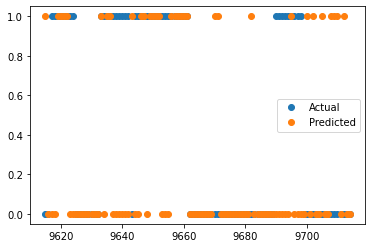

In [24]:
plt.plot(test["Target"], 'o',label = "Actual")
plt.plot(prediction, 'o',label = "Predicted")
plt.legend()
def predict(train, test, predictors, model):
    model.fit(train[predictors],train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds,index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"],preds], axis = 1)
    return combined

def backtest(data, model, predictors, start = 2500, step = 250):
    all_prediction = []
    
    for i in range(start,data.shape[0],step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train,test,predictors,model)
        all_prediction.append(predictions)
    return pd.concat(all_prediction)

In [25]:
predictions = backtest(apple,model,features)
predictions["Predictions"].value_counts()

0    4521
1     703
Name: Predictions, dtype: int64

In [26]:
precision_score(predictions["Target"],predictions["Predictions"])

0.4694167852062589

In [27]:
year_values = [2,5,60,250]
new_predictors = []

for h in year_values:
    rolling_avg = apple.rolling(h).mean()
    ratio_column = f"Close_Ratio_{h}"
    apple[ratio_column] = apple["Close"]/rolling_avg["Close"]
    
    trend_column = f"trend_{year_values}"
    apple[trend_column] = apple.shift(1).rolling(h).sum()["Target"]
    
    new_predictors += [ratio_column,trend_column]

In [28]:
apple = apple.dropna()

In [29]:
apple

,Date,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,"trend_[2, 5, 60, 250]",Close_Ratio_5,Close_Ratio_60,Close_Ratio_250
2241,1993-07-20,0.199741,0.211276,0.195992,0.204566,6.240019e+08,0.277643,1,1.023367,129.0,0.878141,0.574195,0.525965
2242,1993-07-21,0.197877,0.203639,0.194278,0.199741,5.348400e+08,0.279757,1,0.988066,129.0,0.923776,0.565231,0.514350
2243,1993-07-22,0.197877,0.205483,0.195992,0.201576,2.477376e+08,0.289238,1,1.004572,129.0,0.997418,0.575328,0.519840
2244,1993-07-23,0.205483,0.209382,0.197877,0.199741,2.742523e+08,0.283396,1,0.995428,129.0,0.997859,0.575331,0.515927
2245,1993-07-26,0.203639,0.209382,0.197877,0.204566,1.792830e+08,0.283396,1,1.011934,129.0,1.012512,0.594418,0.529238
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9710,2023-03-20,155.070000,157.820000,154.150000,157.400000,7.364142e+07,152.870000,0,1.007682,125.0,1.017019,1.095202,1.050117
9711,2023-03-21,157.320000,159.400000,156.540000,159.280000,7.393828e+07,150.590000,0,1.005937,125.0,1.020345,1.105228,1.062908
9712,2023-03-22,159.300000,162.140000,157.810000,157.830000,7.570181e+07,148.500000,0,0.995427,125.0,1.004826,1.091934,1.053559
9713,2023-03-23,158.830000,161.550100,157.680000,158.930000,6.762206e+07,150.470000,0,1.003473,125.0,1.007876,1.096123,1.061308


In [30]:
model = RandomForestClassifier(n_estimators = 200,min_samples_split = 50,random_state = 1)

In [31]:
def predict(train, test, predictors, model):
    model.fit(train[predictors],train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds>=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds,index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"],preds], axis = 1)
    return combined

In [32]:
predictions = backtest(apple,model,new_predictors)

In [33]:
predictions["Predictions"].value_counts()

0.0    3552
1.0    1422
Name: Predictions, dtype: int64

In [34]:
precision_score(predictions["Target"],predictions["Predictions"])

0.8023909985935302